## Approche statistiques avec Statsmodels

    1. Sachant que les modèles ARIMA et SARIMA sont des régression linéaires qui prennent comme variables explicatives les “lags” (les états précédents) de notre time série. Pourquoi est-on si attaché au fait que notre série temporelle soit stationnaire?

La stationnarité est essentielle pour ces modèles car elle permet de rendre les lags non colinéaires. Ainsi ces derniers peuvent être considérés comme des variables explicatives indépendantes qui apportent une information distinctes de la tendance et de la saisonalité. Ce qui permet d'améliorer la précision du modèle en incluant les ecarts avec la régression linéaire.

    2. Qu’est qu’un modèle AR ?

Un modèle auto-regressif est un modèle qui utilise les valeurs passées d'une série temporelle pour prédire sa valeur future.

    À quoi correspond le paramètre p ?

C'est l'ordre de régression, le nombre de valeurs passées utilisées pour prédire la valeur future de la série.

    3. Qu’est ce qu’un modèle MA ?

Le modèle Mobile Average est un modèle qui utilise les erreurs passées pour prédire sa valeur future.

    À quoi correspond le paramètre q?

L'ordre de la moyenne mobile, le nombre de valeurs passées utilises pour prédire la valeur future.

    4. Qu’est ce que le modèle ARIMA ?

Le modèle ARMA combine l'auto-régression d'AR et la moyenne mobile de MA, tout en intégrant les différenciations intégrées (I) qui permettent de rendre la série stationnaire.

    À quoi correspond le paramètre d?

C'est l'ordre de la différenciation intégrée, le nombre de différenciations nécessaires pour rendre la série stationnaire avant de modéliser les termes AR et MA.

    5. Qu’est ce que le modèle SARIMA ?

C'est une extension du modèle ARIMA qui prend en compte la saisonnalité de la série temporelle.

    À quoi correspond le paramètre s?

C'est la plage temporelle de la saisonnalité que l'on a observé, donc le nombre d'observations à inclure pour analyser le processus intégralement.

# Modélisation

In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, statsmodels.api as sm, numpy as np

In [2]:
df_hdf = pd.read_csv('data/hdf_dataset.csv', index_col='date_heure', parse_dates=True) #Import
df_hdf.index = pd.to_datetime(df_hdf.index, utc=True) #Conversion en datetime
df_day = df_hdf.resample('D').mean() #Aggregation par jour
        ### Préparation du dataset

    Déterminer les paramètres s, d, q, p  à l’aide des graphiques d’autocorrélation et d’autocorrélation partielle, ainsi qu’à l’aide des graphiques de la première partie.   
    - Déterminer d’abord s et appliquer la désaisonnalisation
    - Sur la série désaisonnalisée recherchez d et détrendez
    - Sur la série détrendée, recherchez q et p


<Axes: xlabel='date_heure'>

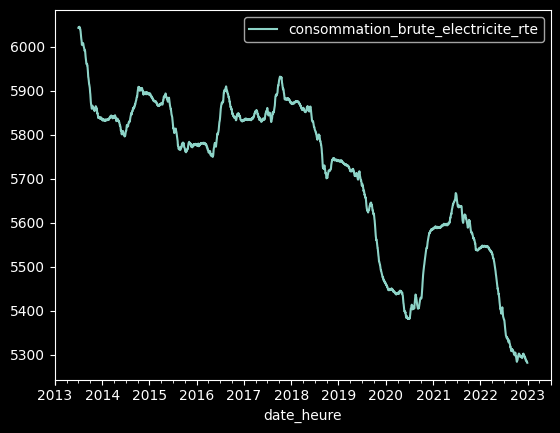

In [3]:
s = 365      # Saisonnalité annuelle (comme observé dans A___Analysis)

df_s = df_day.rolling(window=s,center=True, win_type=None).mean() # Désaissonalisation
plt.style.use('dark_background')
df_s.plot()   

^^^ Visuellement, une fois désaisonnalisée la série , peut être assimilée à tendance linéaire (d = 1), ou sinusoïdale (d = 3). On choisit la version plus simple

In [4]:
d = 1  # Nombre de dérivées à faire pour retirer la trend

<Axes: xlabel='date_heure'>

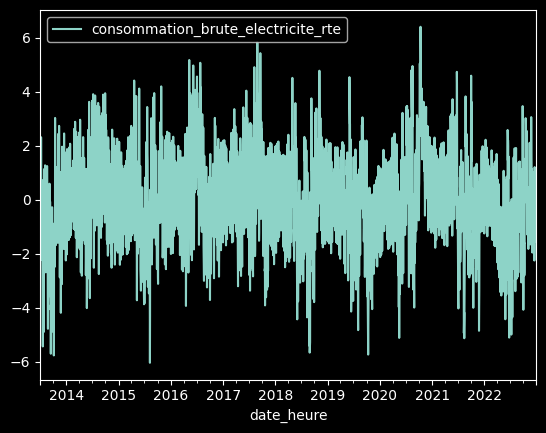

In [5]:
df_s_d = df_s.diff(d).dropna() # Dérive le nombre de fois nécessaire pour détrend / puis on retire les NaN
df_s_d.plot()

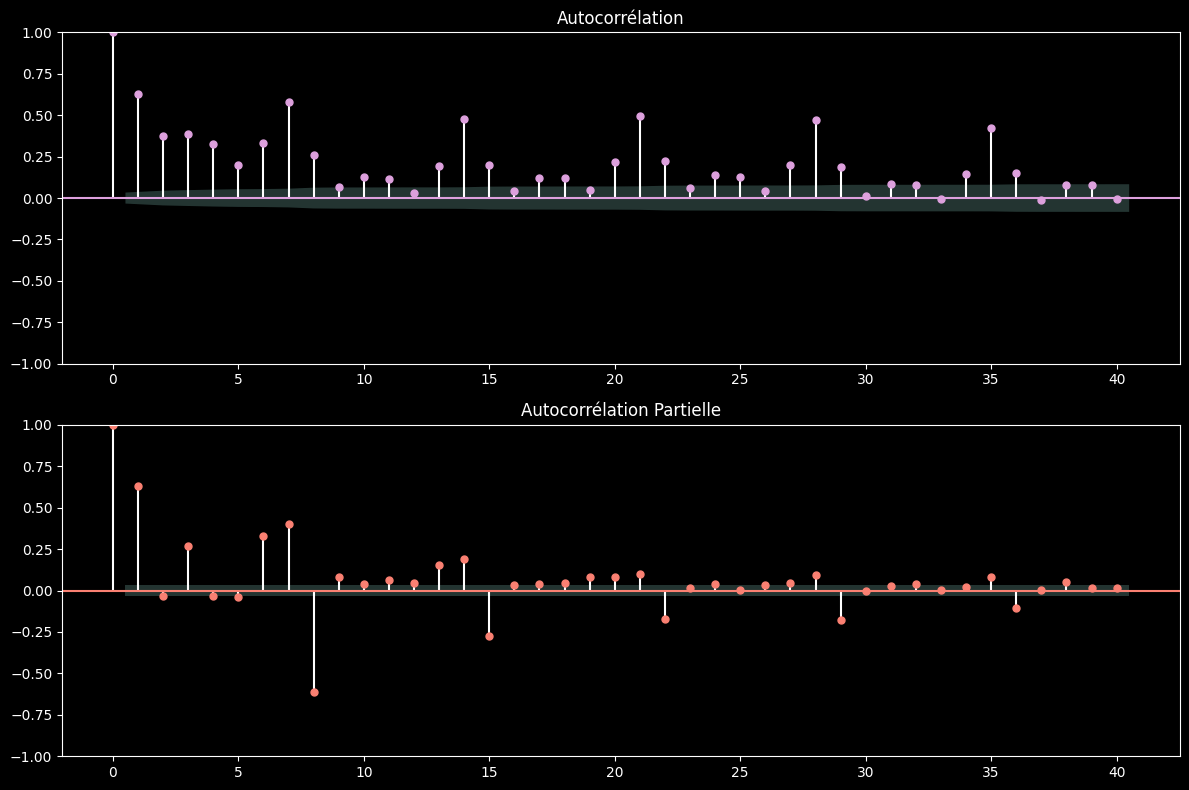

In [6]:
acf = sm.tsa.acf(df_s_d, fft=True)     # autocorrélation
pacf = sm.tsa.pacf(df_s_d)      # autocorrélation partielle

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

sm.graphics.tsa.plot_acf(df_s_d, lags=40, ax=ax1, alpha=0.05, color='plum')
ax1.set_title('Autocorrélation')
sm.graphics.tsa.plot_pacf(df_s_d, lags=40, ax=ax2, alpha=0.05, color='salmon')
ax2.set_title('Autocorrélation Partielle')

plt.tight_layout()
plt.show()


` ^^^ ` Visuellement ici, ~on ignore la première barre~  on peut définir que :  
-le nombre d'observation pour AR doit être de 4, jusqu'à l'inflexion   
-le nombre d'observation pour MA doit être de 1, car la deuxième observation est en dessous du seuil de significativité

In [7]:
s = 7 # S
p = 4 # AR
d = 1 # I
q = 1 # MA

    7. A l’aide statmodels et dans une approche statistique (sans train/test/split), lancez un modèle ARIMA sur la série désaisonnalisée. 

In [8]:
model = sm.tsa.ARIMA(df_s, order=(p, d, q))

results = model.fit()

print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:     consommation_brute_electricite_rte   No. Observations:                 3834
Model:                                 ARIMA(4, 1, 1)   Log Likelihood               -5686.183
Date:                                Tue, 19 Sep 2023   AIC                          11384.366
Time:                                        09:34:20   BIC                          11421.874
Sample:                                    12-31-2012   HQIC                         11397.690
                                         - 06-30-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3331     96.024      0.003      0.997    -187.870     188.536
ar.

    Est ce que tous les paramètres sont significatifs

` ^^^ ` On observe que les coefficients sont modérement significatifs, à l'oeil et les tests de significativités z sont très petits

     Qu’est ce que l’AIC?

Developpé dans les années 1970 par le statisticien Hirotugo Akaike, l'AIC (Akaike Information Criterion) est un critère d'évaluation la modélisation statistique pour comparer et selectionner les modèles.  
De par sa méthode de calcul, il favorise les modèles offrant un bon ajustement aux données sans être trop complexe en utilisant un nombre minimal de paramètres.
En théorie, on peut selectionner le modèle avec l'AIC le plus faible.

    Essayez d’améliorer votre modèle en modifiant les paramètres non significatifs et en vous basant sur le critère de l’AIC.

In [9]:
model = sm.tsa.ARIMA(df_s, order=(4, 1, 1))
results = model.fit()
results.params

ar.L1     0.333094
ar.L2     0.010403
ar.L3     0.203750
ar.L4     0.088693
ma.L1     0.327604
sigma2    1.529937
dtype: float64

In [10]:
results.aic

11384.365811323189

In [11]:
start_params = results.params.copy() # Copie des paramètres afin de chercher l'AIC avec certains coefficients non significatifs à zero
start_params.iloc[0] = 0 
start_params.iloc[1] = 0
start_params.iloc[2] = 0
# start_params.iloc[3] = 0 
# start_params.iloc[4] = 0

best_model = model.fit(start_params=start_params)
best_model.aic

11283.51030484254

` ^^^ ` En fixant ar.L1 à 0, on améliore l'AIC. En retirant également ar.L2 et/ou ar.L3 et/ou ar.L4 on ne descend plus sur l'AIC

    7.Affichez les résidus du meilleurs des modèles que vous avez jusqu’à présent

In [12]:
resid = best_model.resid.dropna()
resid

date_heure
2013-07-01 00:00:00+00:00    6042.525853
2013-07-02 00:00:00+00:00       0.613152
2013-07-03 00:00:00+00:00       0.609378
2013-07-04 00:00:00+00:00      -1.101966
2013-07-05 00:00:00+00:00      -0.008271
                                ...     
2022-12-26 00:00:00+00:00       0.839929
2022-12-27 00:00:00+00:00      -0.691863
2022-12-28 00:00:00+00:00      -0.136698
2022-12-29 00:00:00+00:00      -0.274308
2022-12-30 00:00:00+00:00      -0.705731
Freq: D, Length: 3470, dtype: float64

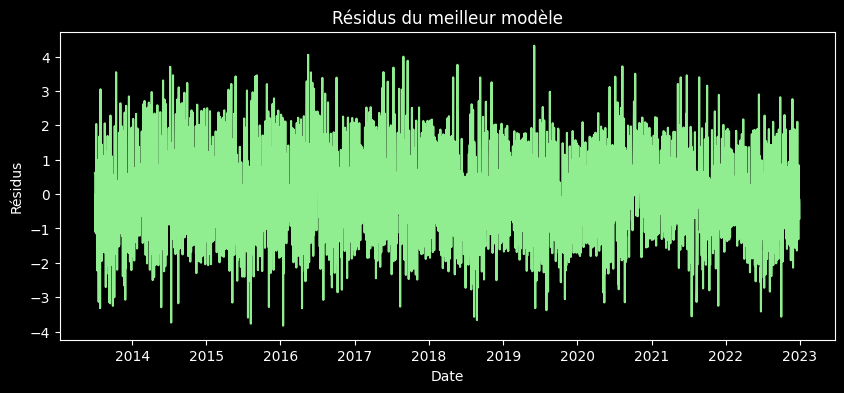

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(resid.index[1:], resid[1:], color = 'lightgreen')
plt.title('Résidus du meilleur modèle')
plt.xlabel('Date')
plt.ylabel('Résidus')
plt.show()

    Pourquoi recherche t-on un bruit blanc ou l’absence de pattern dans ces résidus?

Si les résidus présentent des structures ou des patterns, cela indique que le modèle n'a pas capturé complètement l'information contenue dans les données et remet en question la validité du modèle qui conduira des prédictions éronnées.
Une absence de biais (bruit blanc) indique en revanche que les erreurs sont aléatoires, donc sans structure temporelle, donc imprévisibles.

    Que constatez vous pour le graphique affiché?

On constate un bruit blanc sans pattern avec un écart de -4,4 maximum

    9. Affichez les prédictions du meilleur de vos modèles. Qu’en pensez vous?

In [14]:
from statsmodels.tsa.arima.model import ARIMA

In [15]:
model = ARIMA(df_s, order=(0,1,1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:     consommation_brute_electricite_rte   No. Observations:                 3834
Model:                                 ARIMA(0, 1, 1)   Log Likelihood               -5914.559
Date:                                Tue, 19 Sep 2023   AIC                          11833.119
Time:                                        09:34:32   BIC                          11845.622
Sample:                                    12-31-2012   HQIC                         11837.560
                                         - 06-30-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6865      0.012     55.143      0.000       0.662       0.711
sigma2         1.7452      0.041     42.185      0.000       1.664       1.826
===================================================================================
Ljung-Box (L1) (Q):                  21.62   Jarque-Bera (JB):                99.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='date_heure'>

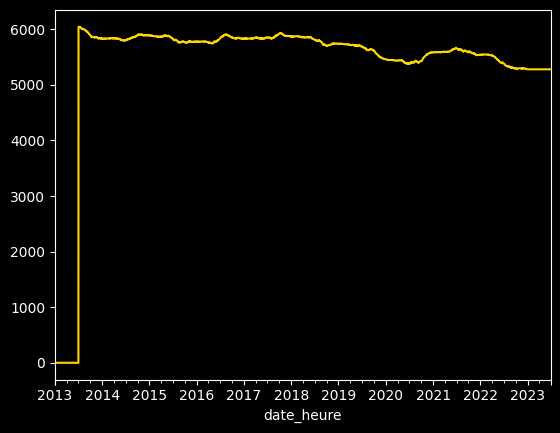

In [16]:
model_fit.predict(dynamic=False).plot(color='gold')

    Qu'en pensez vous ?

Le modèle prédit des valeurs constamment proche de 6000 sans saisonnalité. Il se base uniquement sur le bruit blanc.

    10. Entrainez le même modèle mais cette fois uniquement sur les dates de 2014 à 2020. Affichez les prédictions sur 2021-2022 et comparez aux valeurs réelles. 

In [17]:
from datetime import datetime

In [18]:
# df_s.index = df_s.index.tz_localize('UTC')

In [19]:
df_s.index.tzinfo

datetime.timezone.utc

In [20]:
train = df_s['2014':'2020'].tz_convert(None)
test = df_s['2021':'2022'].tz_convert(None)

In [21]:
model = ARIMA(train, order=(4,1,1))
fitted = model.fit()

In [22]:
predictions = fitted.predict(start='2021', end='2022')


In [23]:
predictions

2021-01-01    5586.700506
2021-01-02    5586.903499
2021-01-03    5587.083706
2021-01-04    5587.225750
2021-01-05    5587.335856
                 ...     
2021-12-28    5587.809393
2021-12-29    5587.809393
2021-12-30    5587.809393
2021-12-31    5587.809393
2022-01-01    5587.809393
Freq: D, Name: predicted_mean, Length: 366, dtype: float64

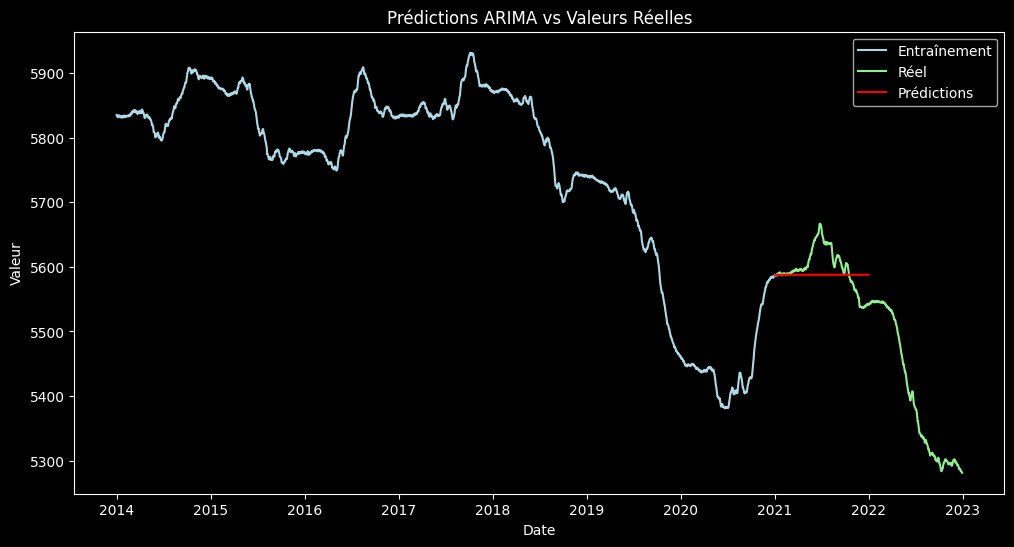

In [24]:
# 4. Comparez les prédictions aux valeurs réelles de l'ensemble de test
plt.figure(figsize=(12, 6))
plt.plot(train, label='Entraînement', color='lightblue')
plt.plot(test, label='Réel', color='lightgreen')
plt.plot(predictions, label='Prédictions', color='red')
plt.title('Prédictions ARIMA vs Valeurs Réelles')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.legend()
plt.show()


    Comment comprenez-vous la différence entre les deux graphiques?

Que le modèle s'adapte trop aux dernières données temporelles

In [25]:
from pmdarima import auto_arima

In [26]:
df_s = df_s.dropna()


In [27]:
model_autoarima = auto_arima(df_s, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11562.321, Time=2.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13317.691, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11580.373, Time=1.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11749.017, Time=2.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13376.611, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11349.305, Time=5.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11578.573, Time=1.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11321.550, Time=4.40 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11321.873, Time=1.99 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10290.667, Time=25.01 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11209.963, Time=10.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9984.376, Time=36.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11202.622, Time=38.86 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=10021.110, Time=20.51 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit t

In [28]:
order = model_autoarima.order
order

(3, 1, 3)

In [29]:
model_arima_auto = ARIMA(df_s, order=order)
results_auto = model_arima_auto.fit()

/home/apprenant/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/apprenant/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/home/apprenant/miniconda3/envs/timeseries/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


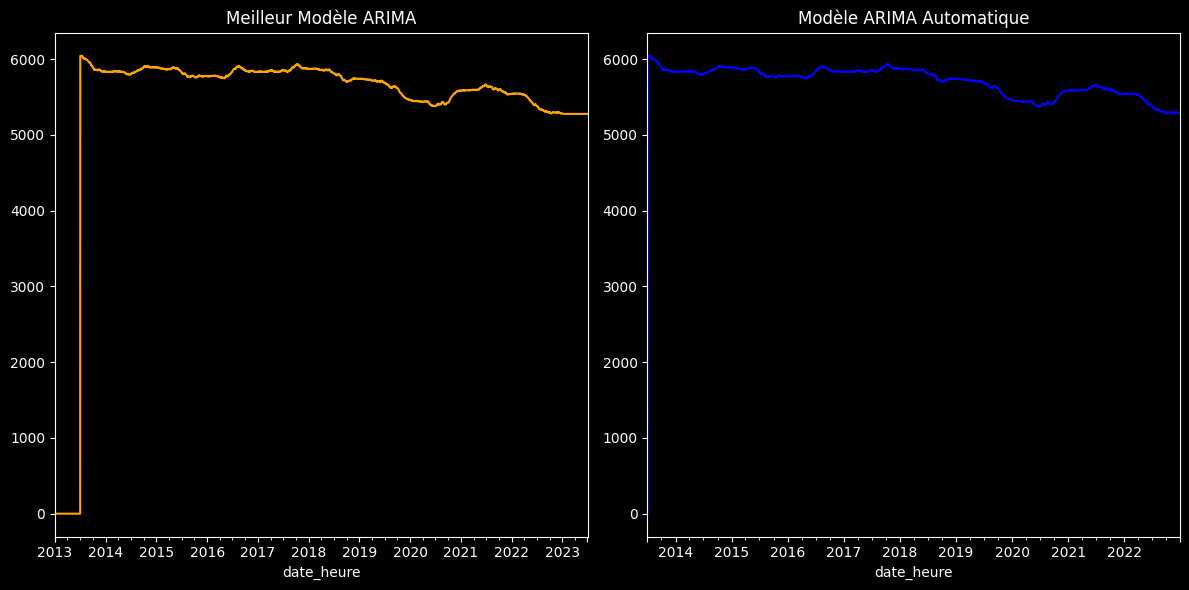

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichez les prédictions du meilleur modèle (best_model) dans le premier sous-graphique (axs[0])
best_model.predict().plot(color='orange', ax=axs[0])
axs[0].set_title('Meilleur Modèle ARIMA')

# Affichez les prédictions du modèle ARIMA automatique (results_auto) dans le deuxième sous-graphique (axs[1])
results_auto.predict().plot(color='blue', ax=axs[1])
axs[1].set_title('Modèle ARIMA Automatique')

plt.tight_layout()
plt.show()



In [31]:
print(f'AIC Arima manuel : {best_model.aic} \n AIC Auto-Arima : {results_auto.aic}')

AIC Arima manuel : 11283.51030484254 
 AIC Auto-Arima : 10021.11008909018


Le tracé des predictions est assez similaire mais l'AIC est meilleur sur l'auto_arima

    12. Comment pourrait-on ajouter à nouveau la composante saisonnière à partir du résultat obtenu.

On pourrait utiliser SARIMA et mettre une saisonnalité à 365 pour représenter la saisonnalité annuelle

    13. Lancez un modèle auto-Arima sur la série originale journalière en incluant les paramètres saisonniers.

In [32]:
# model_autoarima = auto_arima(df_day, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=365,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=True,  
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

` ^^^ ` 365 est un parametre trop important pour le M, la recherche automatique devient trop complexe.
Il faut désaisonnaliser manuellement et utiliser ARIMA pour une série à saisonnalité annuelle.